In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import datetime
from datetime import datetime
from sklearn import linear_model
import pickle
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import random
import seaborn as sns
import imblearn
from sklearn.metrics import precision_recall_curve

### Get HDD models

In [2]:
print("Current Time =", datetime.now().strftime("%H:%M:%S"))

Current Time = 00:21:48


In [3]:
# Modules to get models from HDD data
def getModels(filepath):

    #print('reading hdf5')
    dfinal = pd.read_hdf(filepath)
    

    print("Current Time =", datetime.now().strftime("%H:%M:%S"))
    dfModels = dfinal['model'].drop_duplicates()
    
    return dfModels


def getAllModels(arr,yearArr,dfModelsFinal):
    for filename in arr:
        for year in yearArr:
            filepath = "~/data/"+filename+str(year)+".h5"
            
            dfmodels0 = pd.DataFrame(getModels(filepath))
            
            print(dfmodels0.columns)
            
            dfModelsFinal = pd.concat([dfModelsFinal,dfmodels0], axis = 0)
            
    return dfModelsFinal

In [4]:
# Create empty dataframe to store all availavle HDD models
column_names = ['model']
dfModelsFinal = pd.DataFrame(columns = column_names)

In [5]:
# Get models for 2019 year - Q1, Q2, Q3
arr = ['hdd_1_','hdd_2_','hdd_3_']
yearArr = [2019]
allmodels = getAllModels(arr,yearArr,dfModelsFinal)


Current Time = 00:21:56
Index(['model'], dtype='object')
Current Time = 00:22:05
Index(['model'], dtype='object')
Current Time = 00:22:14
Index(['model'], dtype='object')


In [6]:
allmodels = pd.DataFrame(allmodels['model'].drop_duplicates()).reset_index()
allmodels['modelType'] = allmodels.index

#save all models
allmodels[['model','modelType']].to_csv("~/data/allmodelsFile.csv")

In [7]:
def dataPreprocessing(filepath):

    print('reading hdf5')
    dfinal = pd.read_hdf(filepath)
    #dfinal = pd.read_pkl(filepath)

    print("Current Time =", datetime.now().strftime("%H:%M:%S"))
    dfSorted = dfinal.sort_values(by = ['date','model'])
    dfSorted['modelName'] = dfSorted['model']

    dfModels = dfinal['model'].drop_duplicates().reset_index()
    dfModels['modelType'] = dfModels.index

    dfSorted = pd.merge(left = dfSorted,right = dfModels, how='left', left_on='model',right_on = 'model')

    models = list(dfModels['model'])

    newModelsList=[]
    
    df_fail = dfSorted[dfSorted.failure==1]

    #filter out Models without any failure

    for item in models:
        df_model_fail = df_fail[df_fail.model==item]
        
        if len(df_model_fail)>0:
            newModelsList.append(item)

    print(newModelsList)


    df_updated = dfSorted[dfSorted['model'].isin(newModelsList)]

    print('done ')
    print("Current Time =", datetime.now().strftime("%H:%M:%S"))
    return df_updated

### Load historical data and smart features dictionary

In [8]:
print("Current Time =", datetime.now().strftime("%H:%M:%S"))
df_updated = dataPreprocessing("~/data/hdd_1_2019.h5")
dfModels = pd.read_csv("~/data/allmodelsFile.csv")
dffeatureDict = pd.read_csv("~/data/smartFeaturesDict.csv")

Current Time = 00:22:15
reading hdf5
Current Time = 00:22:22
['ST4000DM000', 'ST12000NM0007', 'HGST HMS5C4040ALE640', 'ST8000NM0055', 'ST8000DM002', 'HGST HMS5C4040BLE640', 'TOSHIBA MG07ACA14TA', 'HGST HUH721212ALN604', 'ST6000DX000', 'TOSHIBA MQ01ABF050', 'ST500LM030', 'ST10000NM0086', 'WDC WD60EFRX', 'TOSHIBA MQ01ABF050M', 'HGST HUH728080ALE600', 'WDC WD5000LPVX', 'ST500LM012 HN', 'WDC WD5000LPCX', 'ST8000DM004', 'HGST HUH721212ALE600']
done 
Current Time = 00:23:27


In [9]:
#adding another quarter of data
#df_updated1 = dataPreprocessing("~/data/hdd_2_2019.h5")
#df_updated = pd.concat([df_updated,df_updated1],axis = 0)
#df_updated['modelType1'] = df_updated['modelType']



### Get unique instances for HDD - all devices and failed drives

In [10]:
#unique serial numbers
df_serialNumbers = df_updated[['model','serial_number']].drop_duplicates()
df_serialNumbersFailes = df_updated[df_updated.failure==1][['model','serial_number']].drop_duplicates()
df_serialNumbersCnt = df_serialNumbers[['model','serial_number']].groupby(by = ['model']).count().rename(columns={'serial_number': 'allCount'})
df_serialNumbersCnt['model'] = df_serialNumbersCnt.index
df_serialNumbersFailesCnt = df_serialNumbersFailes[['model','serial_number']].groupby(by = ['model']).count().rename(columns={'serial_number': 'failCount'})
df_serialNumbersFailesCnt['model'] = df_serialNumbersFailesCnt.index
df_serialNumbersCnt['model_'] = df_serialNumbersCnt['model']
df_serialNumbersFailesCnt['model_'] = df_serialNumbersFailesCnt['model']

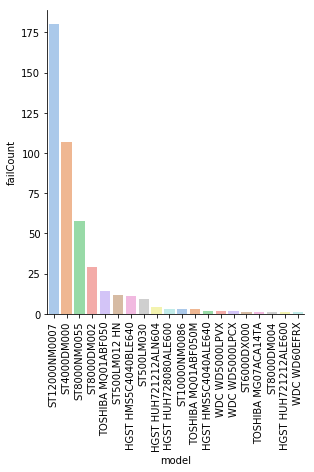

In [11]:
df_serialNumbersFailesCnt = df_serialNumbersFailesCnt.sort_values(by='failCount', ascending = False)
x = df_serialNumbersFailesCnt['model']
y = df_serialNumbersFailesCnt['failCount']
g = sns.catplot(x="model", y="failCount",kind = "bar", palette = "pastel",data=df_serialNumbersFailesCnt).set_titles('Failed devices')
g.set_xticklabels(rotation=90)
#g.set_titles('all devices')

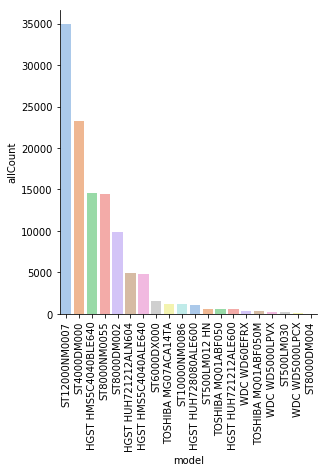

In [12]:
df_serialNumbersCnt = df_serialNumbersCnt.sort_values(by='allCount', ascending = False)
x = df_serialNumbersCnt['model']
y = df_serialNumbersCnt['allCount']
g = sns.catplot(x="model", y="allCount",kind = "bar", palette = "pastel",data=df_serialNumbersCnt).set_titles('all devices')
g.set_xticklabels(rotation=90)
#g.set_titles('all devices')

In [13]:
df_serialNumbersCntPrc=pd.merge(df_serialNumbersCnt,df_serialNumbersFailesCnt, how = 'left', right_on = 'model_',left_on = 'model_')
df_serialNumbersCntPrc['failurePrc'] = 100*(df_serialNumbersCntPrc.failCount/df_serialNumbersCntPrc.allCount)
df_serialNumbersCntPrc = df_serialNumbersCntPrc.sort_values(by = 'failurePrc', ascending = False).rename(columns = {'model_':'model'})





### Percentage of failed models

                   model  failurePrc
19           ST8000DM004   25.000000
17            ST500LM030    4.306220
18        WDC WD5000LPCX    3.571429
12    TOSHIBA MQ01ABF050    2.641509
11         ST500LM012 HN    1.967213
15   TOSHIBA MQ01ABF050M    0.789474
16        WDC WD5000LPVX    0.735294
0          ST12000NM0007    0.515685
1            ST4000DM000    0.460492
3           ST8000NM0055    0.401634
4            ST8000DM002    0.292693
10  HGST HUH728080ALE600    0.286260
14          WDC WD60EFRX    0.261780
9          ST10000NM0086    0.246305
13  HGST HUH721212ALE600    0.191939
5   HGST HUH721212ALN604    0.082034
8    TOSHIBA MG07ACA14TA    0.081566
2   HGST HMS5C4040BLE640    0.075560
7            ST6000DX000    0.065531
6   HGST HMS5C4040ALE640    0.041684


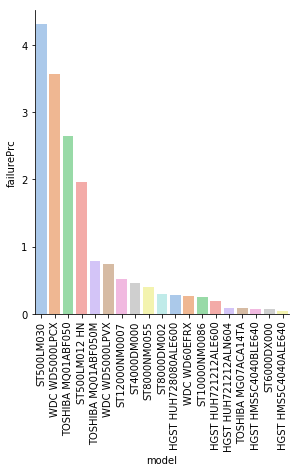

In [125]:
print(df_serialNumbersCntPrc[['model','failurePrc']])
df_serialNumbersCntPrc=df_serialNumbersCntPrc[df_serialNumbersCntPrc.failurePrc<20]
x = df_serialNumbersCntPrc['model']
y = df_serialNumbersCntPrc['failurePrc']
g = sns.catplot(x="model", y="failurePrc",kind = "bar", palette = "pastel",data=df_serialNumbersCntPrc).set_titles('all devices')
g.set_xticklabels(rotation=90)

In [15]:
print( df_serialNumbersCntPrc)

    allCount               model_x                 model  failCount  \
19         4           ST8000DM004           ST8000DM004          1   
17       209            ST500LM030            ST500LM030          9   
18        56        WDC WD5000LPCX        WDC WD5000LPCX          2   
12       530    TOSHIBA MQ01ABF050    TOSHIBA MQ01ABF050         14   
11       610         ST500LM012 HN         ST500LM012 HN         12   
15       380   TOSHIBA MQ01ABF050M   TOSHIBA MQ01ABF050M          3   
16       272        WDC WD5000LPVX        WDC WD5000LPVX          2   
0      34905         ST12000NM0007         ST12000NM0007        180   
1      23236           ST4000DM000           ST4000DM000        107   
3      14441          ST8000NM0055          ST8000NM0055         58   
4       9908           ST8000DM002           ST8000DM002         29   
10      1048  HGST HUH728080ALE600  HGST HUH728080ALE600          3   
14       382          WDC WD60EFRX          WDC WD60EFRX          1   
9     

In [16]:
df_hdd = df_updated[pd.isnull(df_updated.smart_173_raw)]

In [17]:
df_ssd = df_updated[pd.notnull(df_updated.smart_173_raw)]

In [18]:
df_missing = pd.DataFrame(df_hdd.isnull().sum()).rename(columns = {0:'missingCnt'})

In [19]:
df_missingSorted = df_missing.sort_values(by = 'missingCnt', ascending=False)

In [20]:
df_missingSorted['missingPrc'] = df_missingSorted.missingCnt/(len(df_hdd))
df_missingSorted['col'] = df_missingSorted.index

### Feature selection - only features whth less than 25% of mnissing values

In [21]:
columns = df_missingSorted[df_missingSorted.missingPrc<=0.25].reset_index().sort_values(by = 'col')


In [22]:
lst = list(columns['col'])

uniqueCol = ['capacity_bytes']
for item in lst:
    if '_raw' in item:
        uniqueCol.append(item)

In [23]:
print(len(uniqueCol))
print(len(df_hdd), len(df_ssd))
print(len(df_ssd[df_ssd.failure==1]),len(df_hdd[df_hdd.failure==1]))

21
9537453 0
0 444


In [24]:
dfstat = df_hdd.describe()

In [25]:
def pickleToHdfConvert(filepathPkl,filepathHdf):
    df = pd.read_pickle(filepathPkl)
    df.to_hdf(filepathHdf, key='df', mode='w')

#pickleToHdfConvert("~/data/hdd_3_2019.pkl","~/data/hdd_3_2019.h5")

In [26]:
ds = df_hdd

### Resamling

In [27]:
# Resampling health devices
dfFailures = ds[ds.failure==1]
dfSuccess = ds[ds.failure==0].sample(n = 100000)
dfsample =  pd.concat([dfSuccess, dfFailures], axis=0)

In [28]:
dstrain = dfsample[dfsample.capacity_bytes>0]

print(len(dstrain[dstrain.failure==0]),len(dstrain[dstrain.failure==1]),len(dstrain) )



99990 444 100434


In [29]:
simpleFeaturesHist = ['capacity_bytes','modelType','smart_1_raw', 'smart_5_raw', 'smart_7_raw','smart_9_raw', 'smart_12_raw','smart_188_raw','smart_189_raw','smart_190_raw','smart_192_raw', 'smart_194_raw', 'smart_195_raw','smart_197_raw', 'smart_199_raw','smart_200_raw', 'smart_240_raw','smart_241_raw']
#simpleFeatures = ['capacity_bytes','smart_1_raw', 'smart_5_raw', 'smart_7_raw','smart_9_raw', 'smart_12_raw','smart_188_raw','smart_189_raw','smart_190_raw','smart_192_raw', 'smart_194_raw', 'smart_195_raw','smart_197_raw', 'smart_199_raw','smart_200_raw', 'smart_240_raw','smart_241_raw']
smartFeatures = ['smart_1_raw', 'smart_5_raw', 'smart_7_raw','smart_9_raw', 'smart_12_raw','smart_188_raw','smart_189_raw','smart_190_raw','smart_192_raw', 'smart_194_raw', 'smart_195_raw','smart_197_raw', 'smart_199_raw','smart_200_raw', 'smart_240_raw','smart_241_raw']
simpleFeatures_orig = ['capacity_bytes','smart_1_raw', 'smart_5_raw', 'smart_7_raw','smart_9_raw', 'smart_12_raw','smart_188_raw','smart_189_raw','smart_190_raw','smart_192_raw', 'smart_194_raw', 'smart_195_raw','smart_197_raw', 'smart_199_raw','smart_200_raw', 'smart_240_raw','smart_241_raw']

print(len(uniqueCol), len(simpleFeatures_orig))

simpleFeatures = uniqueCol




21 17


In [30]:
print(len(uniqueCol))

21


### Ploting

In [31]:
label = dstrain['failure']

Failure cases consist 0.4 percent of healthy ones


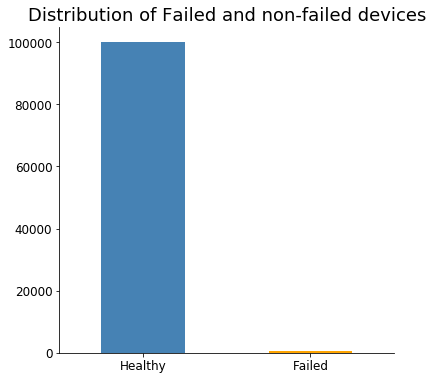

In [32]:
fig=plt.figure(figsize = (6,6))
ax = fig.add_subplot(111)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)    

label.value_counts().plot(kind='bar',
                        color = ['steelblue','orange'], fontsize=12)
#plt.gca().grid(linestyle='-.', linewidth='0.5',axis='y')
ax.set_title("Distribution of Failed and non-failed devices",fontsize=18)
#ax.set_yticks(np.arange(0,16001, 4000))
ax.set_xticklabels(['Healthy','Failed'], rotation=0,fontsize=12)
plt.savefig("classes")
print("Failure cases consist {0:.1f} percent of healthy ones".format(label.value_counts()[1]*100./label.value_counts()[0]))

In [33]:
def violin_plot(x,y,label):
    df = pd.concat([y,x],axis=1)
    df = pd.melt(df,id_vars=label,
                    var_name="features",
                    value_name='value')
    plt.figure(figsize=(12,8))
    sns.violinplot(x="features", y="value", hue=label, 
                   data=df,split=True, inner="quart")
    plt.xticks(rotation=60, fontsize=14)
    plt.ylabel("value", fontsize=18)
   # plt.gcf().subplots_adjust(bottom=0.15)
    plt.tight_layout()
    plt.savefig('violin_plot')
    
    
    

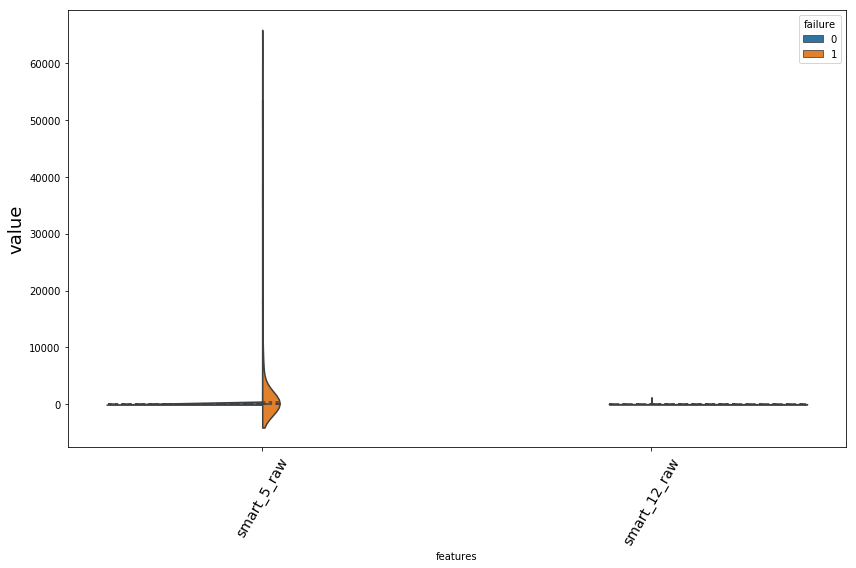

In [34]:
plotFeatures = ['smart_5_raw','smart_12_raw']
#, 'smart_12_raw','smart_188_raw','smart_189_raw','smart_190_raw','smart_192_raw', 'smart_194_raw', 'smart_195_raw','smart_197_raw', 'smart_199_raw','smart_200_raw', 'smart_240_raw','smart_241_raw']

dstrain_plot = dstrain[plotFeatures]
violin_plot(dstrain_plot, label,"failure")

In [35]:
dstrain[simpleFeatures].describe()

,capacity_bytes,smart_10_raw,smart_12_raw,smart_187_raw,smart_188_raw,smart_190_raw,smart_192_raw,smart_193_raw,smart_194_raw,smart_197_raw,...,smart_199_raw,smart_1_raw,smart_240_raw,smart_241_raw,smart_242_raw,smart_3_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw
count,1.004340e+05,1.004330e+05,100433.000000,77900.000000,7.790000e+04,77900.000000,100433.000000,99914.000000,100433.000000,100433.000000,...,100433.000000,1.004330e+05,7.995400e+04,7.804500e+04,7.804500e+04,100433.000000,100433.000000,100433.000000,1.004330e+05,100433.000000
mean,7.824173e+12,3.784818e+01,5.709428,0.139936,1.113740e+08,29.254852,173.064083,13904.461857,29.248394,0.340038,...,0.435982,9.527274e+07,9.518612e+11,4.410634e+10,9.807640e+10,197.694642,8.455717,18.101968,1.483527e+09,17077.997630
std,3.570190e+12,4.062738e+03,11.316384,8.890761,3.364799e+09,6.195263,1111.709046,35792.642753,5.822056,27.110437,...,25.315539,8.059817e+07,1.339866e+13,1.364921e+10,1.740582e+11,993.516583,135.658144,612.750766,3.712063e+10,10251.180567
min,1.374390e+11,0.000000e+00,0.000000,0.000000,0.000000e+00,15.000000,0.000000,1.000000,15.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.480000e+03,0.000000,1.000000,0.000000,0.000000e+00,0.000000
25%,4.000787e+12,0.000000e+00,2.000000,0.000000,0.000000e+00,24.000000,1.000000,432.000000,25.000000,0.000000,...,0.000000,7.965304e+06,8.673000e+03,4.087328e+10,7.572805e+10,0.000000,3.000000,0.000000,1.751066e+07,9566.000000
50%,8.001563e+12,0.000000e+00,4.000000,0.000000,0.000000e+00,29.000000,20.000000,1556.000000,29.000000,0.000000,...,0.000000,8.760416e+07,1.357850e+04,4.671350e+10,1.026835e+11,0.000000,5.000000,0.000000,3.542582e+08,15680.000000
75%,1.200014e+13,0.000000e+00,7.000000,0.000000,0.000000e+00,34.000000,130.000000,14434.750000,33.000000,0.000000,...,0.000000,1.674386e+08,2.590175e+04,5.290162e+10,1.228854e+11,0.000000,7.000000,0.000000,8.910637e+08,25334.000000
max,1.400052e+13,1.114112e+06,1231.000000,1723.000000,6.013057e+11,58.000000,33282.000000,695377.000000,58.000000,6536.000000,...,4135.000000,2.441354e+08,2.813204e+14,1.358498e+11,2.637491e+13,9700.000000,25122.000000,61752.000000,1.082120e+13,49560.000000


In [36]:
def box_plot(x,y,label):
    df = pd.concat([y,x],axis=1)
    df = pd.melt(df,id_vars=label,
                    var_name="features",
                    value_name='value')
    plt.figure(figsize=(12,8))
    sns.boxplot(x="features", y="value", hue=label, 
                   data=df)
    plt.xticks(rotation=60, fontsize=14)
    plt.ylabel("value", fontsize=18)
    plt.tight_layout()
    plt.savefig('box_plot')

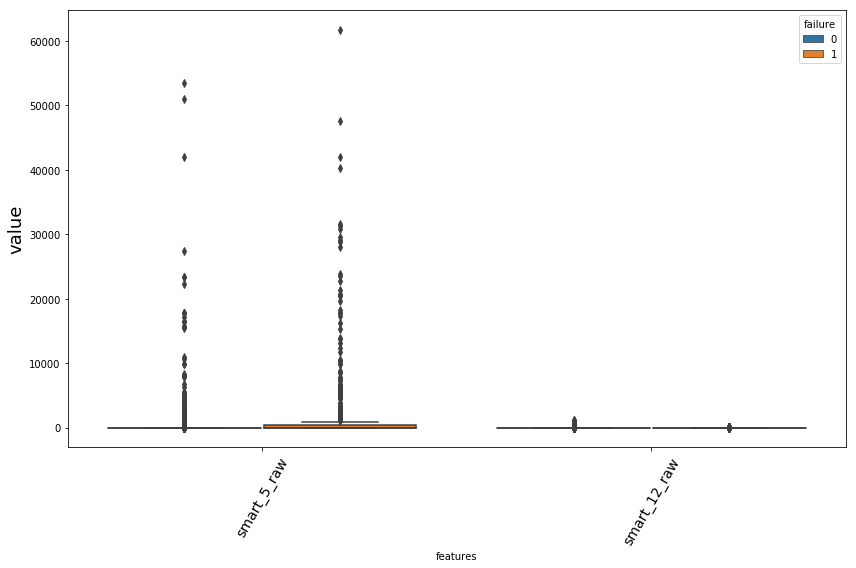

In [37]:
box_plot(dstrain[plotFeatures], label,"failure")

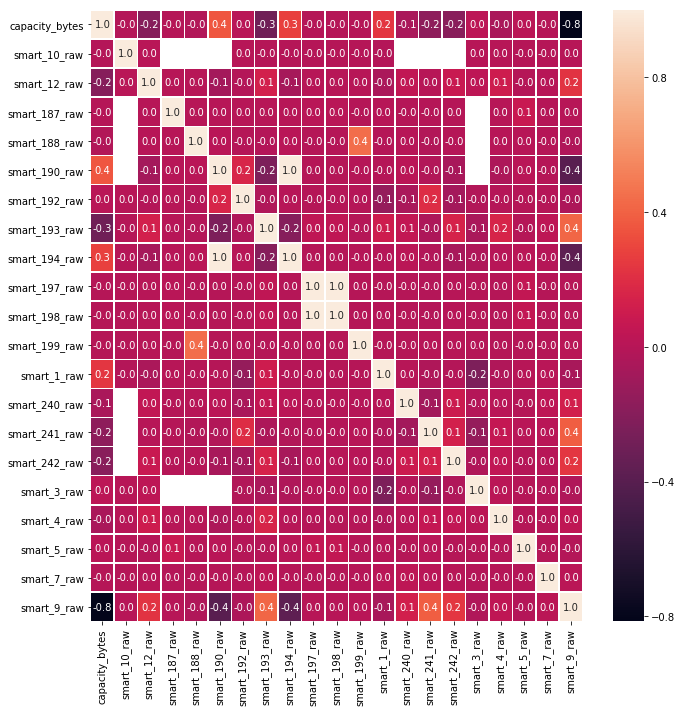

In [38]:
#correlation map
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(dstrain[uniqueCol].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.tight_layout()
plt.savefig('heatmap')

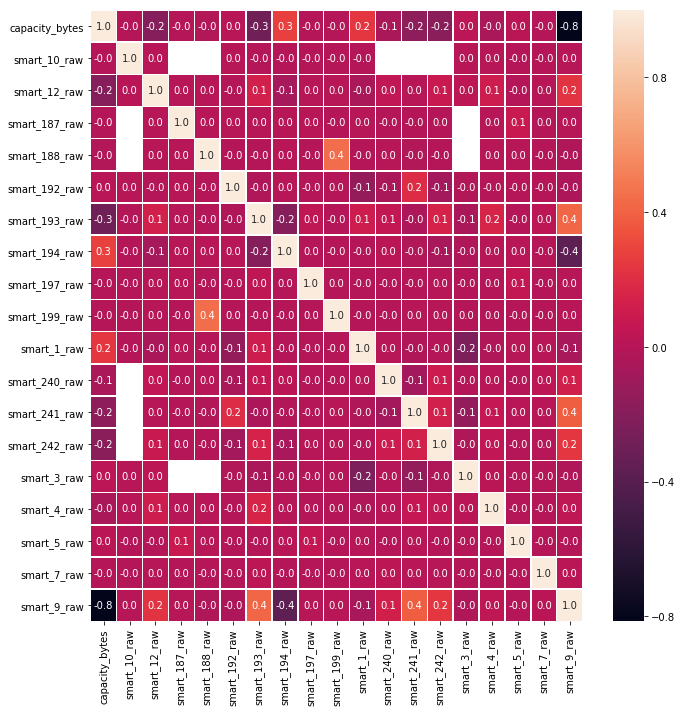

In [39]:
#exclude fetures which have high correlation: 
#190 correlate with 194 and 198 correlates with 197
simpleFeatures = ['capacity_bytes', 'smart_10_raw', 'smart_12_raw', 'smart_187_raw', 'smart_188_raw', 'smart_192_raw', 'smart_193_raw', 'smart_194_raw', 'smart_197_raw',  'smart_199_raw', 'smart_1_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw', 'smart_3_raw', 'smart_4_raw', 'smart_5_raw', 'smart_7_raw', 'smart_9_raw']

#correlation map after feqture exclusion
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(dstrain[simpleFeatures].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.tight_layout()
plt.savefig('heatmap')

In [40]:
def dist_plot(df,feature, size_bin) :  
    failed = df.loc[df['failure']==1, feature]
    nonFailed = df.loc[df['failure']==0, feature]
    hist_data = [ nonFailed,failed]
    
    fig,ax = plt.subplots(figsize=(8, 6))
    ax = sns.distplot(failed, 
                     bins=size_bin,
                     label="Failed")
    ax = sns.distplot(nonFailed,
                    bins=size_bin,
                    label="Healthy")
    ax.set_title(feature, fontsize=18)
    sns.despine()
    plt.tight_layout()
    ax.set(xlabel='')
    plt.legend()
    plt.savefig(feature)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


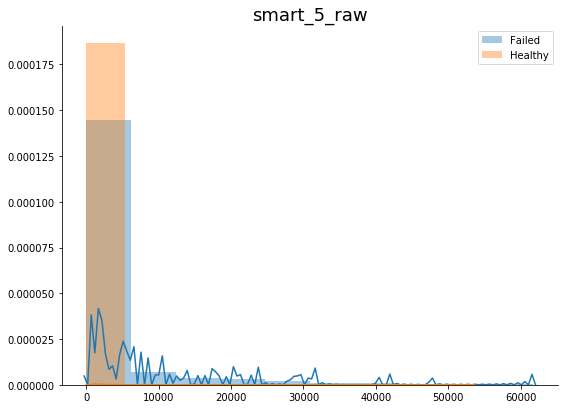

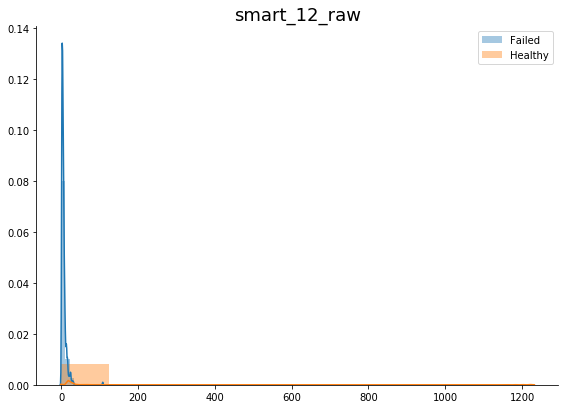

In [41]:
for col in plotFeatures:
    dist_plot(dstrain,col,10)

In [42]:
dfFailures = dstrain[dstrain.failure==1]
dfSuccess = dstrain[dstrain.failure==0]

In [43]:
dfFailStat = dfFailures.describe()
dfSuccessStat = dfSuccess.describe()

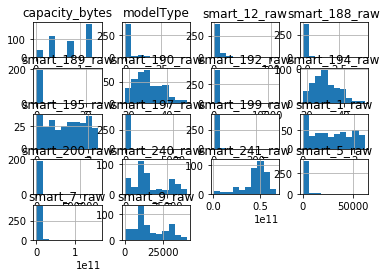

In [44]:
dfFailures[simpleFeaturesHist].hist()
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f765f8b7d30>,
      dtype=object)

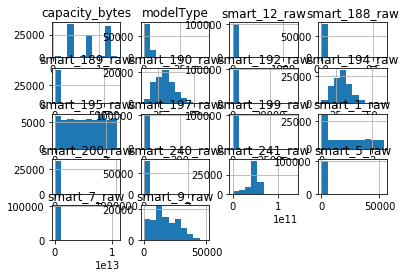

In [45]:
dfSuccess[simpleFeaturesHist].hist()

In [46]:

#for item in simpleFeaturesHist:
#    dfFailures[item].hist()
#    plt.title('Failure, '+ str(item))

    #dfSuccess[item].hist()
    #plt.title('NON - Failure, '+ str(item))
#    plt.show()
#counts, bins = np.histogram(dfFailures[['smart_194_raw']])
#plt.hist(bins[:-1], bins, weights=counts)
#plt.hist(dfFailures[['smart_194_raw']].dropna(), 50, density=True, facecolor='g', alpha=0.75)
#plt.show()

In [47]:
#for item in simpleFeaturesHist:
#   # dfFailures[item].hist()
    #plt.title('Failure, '+ str(item))

#    dfSuccess[item].hist()
#    plt.title('NON - Failure, '+ str(item))
#    plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f765f841f98>]],
      dtype=object)

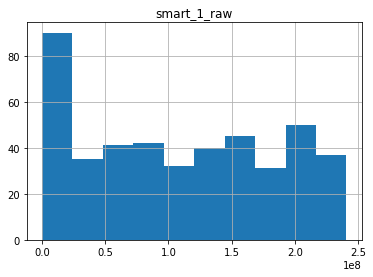

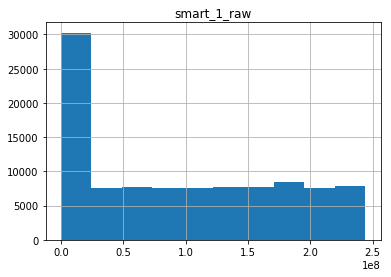

In [48]:
dfFailures[['smart_1_raw']].hist()
dfSuccess[['smart_1_raw']].hist()

In [49]:
#sm9_fail = dfFailures[['smart_9_raw']].hist()
#sm_9 = dfSuccess[['smart_9_raw']].hist()
#print(sm_9)
#plt.show()

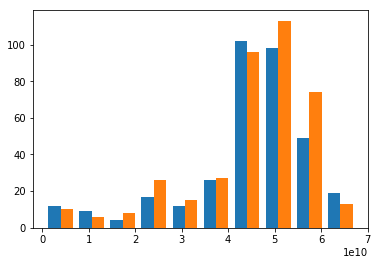

In [50]:
x=list(dfSuccess.sample(n=len(dfFailures)).smart_241_raw)
y=list(dfFailures.smart_241_raw)
plt.hist([x, y])
plt.show()
#sns.distplot([x, y])

In [51]:
#dfFailures[['smart_10_raw']].hist()
#dfSuccess[['smart_10_raw']].hist()

In [52]:
eda_fail = pd.DataFrame(dfFailures[simpleFeaturesHist].describe())
eda_success = pd.DataFrame(dfSuccess[simpleFeaturesHist].describe())

In [138]:
dfmean = pd.DataFrame(dfFailures[simpleFeatures].mean()).rename(columns={0: 'Fail'})
dfmean = pd.DataFrame(list(dfmean['Fail'])).rename(columns={0: 'Fail'})
dfmedian = dfFailures[simpleFeatures].median()

dfmeanSuccess = pd.DataFrame(dfSuccess[simpleFeatures].sample(n=600).mean()).rename(columns={0: 'nonFail'})
dfmeanSuccess = pd.DataFrame(list(dfmeanSuccess['nonFail'])).rename(columns={0: 'nonFail'})

dfcolumns = pd.DataFrame(simpleFeatures).rename(columns={0:'name'})




dfallMean = pd.merge(left = dfcolumns,right=dfmean, how = 'left', right_index=True,left_index=True)
dfallMean = pd.merge(left = dfallMean,right=dfmeanSuccess, how = 'left', right_index=True,left_index=True)
#print(dfallMean)

dfmeantest = dfallMean
dfmeanhours =  dfmeantest[dfmeantest.name =='smart_9_raw'] 
dfmeanNothours =  dfmeantest[dfmeantest.name !='smart_9_raw'] 

dfmeanhours['Fail'] = [x  for x in dfmeanhours['Fail']]
dfmeanhours['nonFail'] = [x  for x in dfmeanhours['nonFail']]

dfmeantest = pd.concat([dfmeanNothours,dfmeanhours], axis = 0)




print(dfmeantest)
dfallMean.to_csv("~/data/allmean.csv")

              name          Fail       nonFail
0   capacity_bytes  7.886056e+12  7.789096e+12
1     smart_10_raw  2.514926e+03  1.666667e-03
2     smart_12_raw  6.207675e+00  5.426667e+00
3    smart_187_raw  1.148837e+01  4.411765e-02
4    smart_188_raw  5.771134e+08  4.511617e+07
5    smart_192_raw  1.063905e+02  2.134883e+02
6    smart_193_raw  1.771082e+04  1.461312e+04
7    smart_194_raw  3.018736e+01  2.902000e+01
8    smart_197_raw  5.727540e+01  2.666667e-02
9    smart_199_raw  1.270880e+00  1.583333e-01
10     smart_1_raw  1.075678e+08  9.943079e+07
11   smart_240_raw  1.514161e+04  1.207395e+12
12   smart_241_raw  4.487619e+10  4.368621e+10
13   smart_242_raw  9.872776e+10  9.550546e+10
14     smart_3_raw  1.680519e+02  2.149133e+02
15     smart_4_raw  7.555305e+00  1.200667e+01
16     smart_5_raw  2.352260e+03  9.500000e-01
17     smart_7_raw  1.828387e+09  2.783130e+09
18     smart_9_raw  1.645013e+04  1.705711e+04


/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [54]:
eda_fail.to_csv("~/data/eda_fail.csv")
eda_success.to_csv("~/data/eda_success.csv")

In [55]:
from imblearn.over_sampling import SMOTE

### Get training data - upsampling

In [56]:
print(len(simpleFeatures))

19


In [57]:
Y = dstrain[['failure']]

X = dstrain[simpleFeatures]


X_train0 = X
y_train0 = Y

print("Number transactions X_train dataset: ", X_train0.shape)
print("Number transactions y_train dataset: ", y_train0.shape)


print("Current Time =", datetime.now().strftime("%H:%M:%S"))

X_train = X_train0.fillna(0)




print('Handling imbalanced data - starting SMOTE ...')


def overSamplingWithSMOTE(X_train,y_train0):
    sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)

    #convert pandas to array
    y_train = np.array(y_train0.failure)

    #Create final training dataset
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    return X_train_res, y_train_res


X_train_res, y_train_res = overSamplingWithSMOTE(X_train,y_train0)

Number transactions X_train dataset:  (100434, 19)
Number transactions y_train dataset:  (100434, 1)
Current Time = 00:24:55
Handling imbalanced data - starting SMOTE ...


In [58]:
def readingTestDataset(filepath, dfModels, features):
    dsTest0 = pd.read_hdf(filepath)
    dsTest = dsTest0[dsTest0.capacity_bytes > 0]
    dsTest = pd.merge(left=dsTest, right=dfModels, how='left', left_on='model', right_on='model')
    
    #dsTest = dsTest[dsTest.model.isin(models)]
    # validate for another quarter
    
    #filtering out SSD
    dsTest = dsTest[pd.isnull(dsTest.smart_173_raw)]
    
    

    #filter out Models without any failure   
    
    Xtest = dsTest[features]
    Ytest = dsTest[['failure']]
    X1test = Xtest.fillna(0)

    return X1test, Ytest

In [59]:
def readingUserTestData(filepath, dfModels, features):
   
    
    ds = pd.read_csv(filepath).fillna(0)
    #dfModels = pd.read_csv(modelfile)

    dsTest = ds[ds.capacity_bytes > 0]
    dsTest = pd.merge(left=dsTest, right=dfModels, how='left', left_on='model', right_on='model')
    

    #simpleFeatures = ['capacity_bytes','smart_1_raw', 'smart_5_raw', 'smart_7_raw','smart_9_raw', 'smart_12_raw','smart_188_raw','smart_189_raw','smart_190_raw','smart_192_raw', 'smart_194_raw', 'smart_195_raw','smart_197_raw', 'smart_199_raw',
    #                  'smart_200_raw', 'smart_240_raw','smart_241_raw']

    simpleFeatures = features

    # validate for another quarter
    info = dsTest[['date','serial_number','model','capacity_bytes']]
    Xtest = dsTest[simpleFeatures]
    Ytest = dsTest[['failure']]
    X1test = Xtest.fillna(0)
    Ytest = dsTest[['failure']]

    #filtering out SSD
    #dsTest = dsTest[pd.isnull(dsTest.smart_173_raw)]
    
    

    #filter out Models without any failure   
    
    Xtest = dsTest[features]
    Ytest = dsTest[['failure']]
    X1test = Xtest.fillna(0)

    return X1test, Ytest, info

### Get test data

In [60]:
%time    Xtest,Ytest = readingTestDataset("~/data/hdd_2_2019.h5",dfModels, simpleFeatures)


CPU times: user 46.1 s, sys: 43.1 s, total: 1min 29s
Wall time: 1min 9s


In [61]:
#Xtest_user,Ytest_user, info_user = readingUserTestData("~/data/2019-09-26.csv",dfModels, simpleFeatures)

#print(len(Ytest_user[Ytest_user.failure==1]))
#print(Ytest_user)

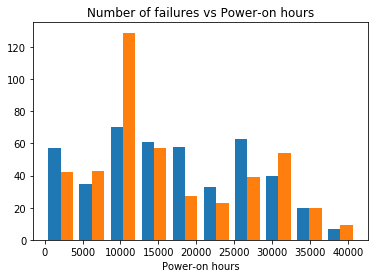

In [62]:
x=list(dfSuccess.sample(n=len(dfFailures)).smart_9_raw)
y=list(dfFailures.smart_9_raw)
plt.hist([x,y])
plt.title("Number of failures vs Power-on hours")
plt.xlabel("Power-on hours")
plt.show()

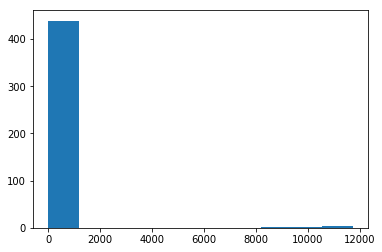

In [63]:
x=list(dfSuccess.sample(n=len(dfFailures)).smart_192_raw)
y=list(dfFailures.smart_192_raw)
plt.hist([x])
plt.show()
df_192 = dfFailures[dfFailures.smart_192_raw>10][['model','smart_192_raw']].sort_values(by = 'smart_192_raw', ascending = False)
#y=list(df_192.smart_192_raw)
#plt.scatter(x,y)
#plt.show()
#print(df_192)

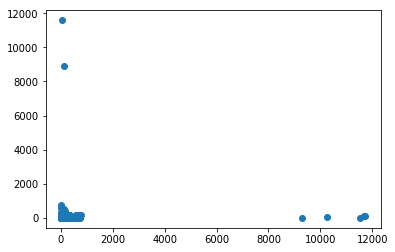

In [64]:
plt.scatter(x,y)
plt.show()

In [65]:
print(len(y_train_res))
y_res =  pd.DataFrame(y_train_res).rename(columns = {0:'fail'})
print(len(y_res), len(y_res[y_res.fail==1]),len(y_res[y_res.fail==0]) ,len(y_res[y_res.fail==1])/len(y_res[y_res.fail==0]) )

199980
199980 99990 99990 1.0


## Model

### 1. Logistic regression

In [66]:
def logisticRegression(X_train_res, y_train_res, Xtest, Ytest,file_name):
    #clfLR = LogisticRegression(penalty = 'l2', solver = 'saga',tol = 1e-6).fit(X_train_res, y_train_res)
    #clfLR = LogisticRegression(C=0.05).fit(X_train_res, y_train_res)
    clfLR = LogisticRegression(penalty = 'l2').fit(X_train_res, y_train_res)


    #(penalty = 'l1', solver = 'liblinear',tol = 1e-6, max_iter = int(1e6),warm_start = True,intercept_scaling = 10000.)

    #predictions2 = clf2.predict(Xtest)

    filename = file_name +'.sav'
    pickle.dump(clfLR, open(filename, 'wb'))
    return clfLR

In [67]:
def predicProbaFromModelFile(modelFile,clfLR, Xtest, Ytest,type):
    if type =='file':
        loaded_model = pickle.load(open(modelFile, 'rb'))
    else:
        loaded_model = clfLR
    predictions = loaded_model.predict(Xtest)
    probability = loaded_model.predict_proba(Xtest)
    precision, recall, thresholds = precision_recall_curve(Ytest, probability[:,1]) 
    #retrieve probability of being 1(in second column of probs_y)
    #pr_auc = metrics.auc(recall, precision)
    return predictions, probability[:,1], recall, thresholds




In [68]:
clfLR = logisticRegression(X_train_res, y_train_res, Xtest, Ytest,'finalized_model_20200225')

In [69]:
predictionsLR = clfLR.predict(Xtest)
probabilityLR = clfLR.predict_proba(Xtest)
classes = ['non-fail','fail']
predictionsLR, userProbaLR, recallLR, thresholdsLR = predicProbaFromModelFile('finalized_model_20200225.sav',clfLR,Xtest, Ytest,'')



In [70]:
print(classification_report(Ytest, predictionsLR, digits=4))
print(confusion_matrix(Ytest, predictionsLR))



              precision    recall  f1-score   support

           0     1.0000    0.4253    0.5968   9826876
           1     0.0001    0.7271    0.0001       513

    accuracy                         0.4253   9827389
   macro avg     0.5000    0.5762    0.2985   9827389
weighted avg     0.9999    0.4253    0.5968   9827389

[[4179613 5647263]
 [    140     373]]


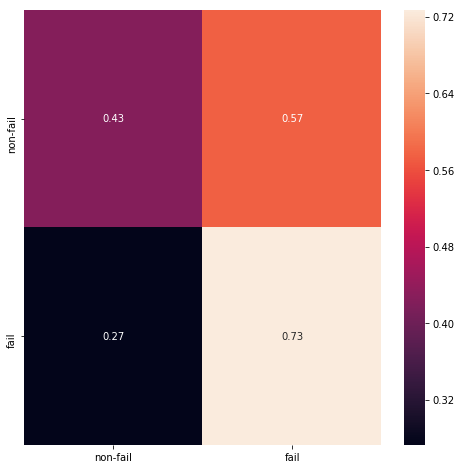

In [71]:
cm = confusion_matrix(Ytest, predictionsLR)
normed_c = (cm.T / cm.astype(np.float).sum(axis=1)).T
# Normalise
#cmn = cm.astype('float')
#cm.sum(axis=0)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(normed_c, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes)
#plt.ylabel('Actual')
#plt.xlabel('Predicted')
plt.show(block=False)

(0, 1)

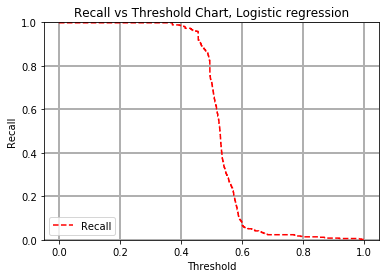

In [72]:
#precision, recall, thresholds = precision_recall_curve(Ytest, clf2.predict_proba(Xtest)[:,1]) 

plt.title("Recall vs Threshold Chart, Logistic regression")
#plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholdsLR, recallLR[: -1], "r--", label="Recall")
plt.ylabel("Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.grid(linestyle='-', linewidth=2)
plt.ylim([0,1])

### Validation - Q3 2019

In [73]:
%time    Xval,Yval = readingTestDataset("~/data/hdd_3_2019.h5",dfModels, simpleFeatures)



CPU times: user 37.5 s, sys: 25.8 s, total: 1min 3s
Wall time: 57.8 s


In [74]:
predictionsLR = clfLR.predict(Xval)
probabilityLR = clfLR.predict_proba(Xval)
print(classification_report(Yval, predictionsLR, digits=4))
print(confusion_matrix(Yval, predictionsLR))




              precision    recall  f1-score   support

           0     1.0000    0.4089    0.5805  10213572
           1     0.0001    0.6949    0.0001       626

    accuracy                         0.4089  10214198
   macro avg     0.5000    0.5519    0.2903  10214198
weighted avg     0.9999    0.4089    0.5804  10214198

[[4176583 6036989]
 [    191     435]]


In [75]:
predictionsLR, userProbaLR, recallLR, thresholdsLR = predicProbaFromModelFile('finalized_model_20200225.sav',clfLR,Xval, Yval,'')



(0, 1)

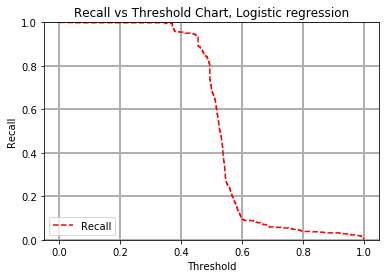

In [76]:
#precision, recall, thresholds = precision_recall_curve(Ytest, clf2.predict_proba(Xtest)[:,1]) 

plt.title("Recall vs Threshold Chart, Logistic regression")
#plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholdsLR, recallLR[: -1], "r--", label="Recall")
plt.ylabel("Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.grid(linestyle='-', linewidth=2)
plt.ylim([0,1])

In [77]:
#print (Xtest_user)

In [78]:
def predicProbaFromModelFile(modelFile,clfLR, Xtest, Ytest,type):
    if type =='file':
        loaded_model = pickle.load(open(modelFile, 'rb'))
    else:
        loaded_model = clfLR
    predictions = loaded_model.predict(Xtest)
    probability = loaded_model.predict_proba(Xtest)
    precision, recall, thresholds = precision_recall_curve(Ytest, probability[:,1]) 
    #retrieve probability of being 1(in second column of probs_y)
    #pr_auc = metrics.auc(recall, precision)
    return predictions, probability[:,1], recall, thresholds

#predictionsLR, userProbaLR, recallLR, thresholdsLR = predicProbaFromModelFile('finalized_model_20200215.sav',clfLR,Xtest, Ytest,'')
#print(classification_report(Ytest, predictionsLR,digits = 4))
#print(confusion_matrix(Ytest, predictionsLR))


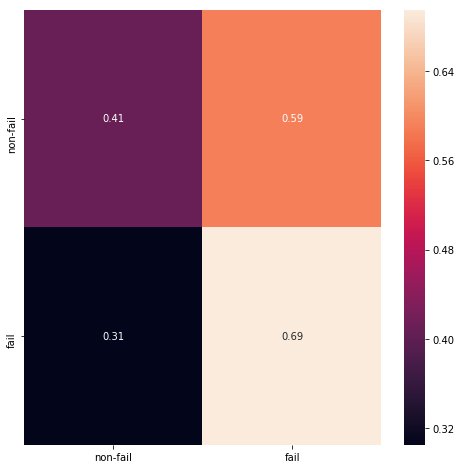

In [79]:
cm = confusion_matrix(Yval, predictionsLR)
normed_c = (cm.T / cm.astype(np.float).sum(axis=1)).T
# Normalise
#cmn = cm.astype('float')
#cm.sum(axis=0)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(normed_c, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes)
#plt.ylabel('Actual')
#plt.xlabel('Predicted')
plt.show(block=False)

### Plotting recall vs threshold

(0, 1)

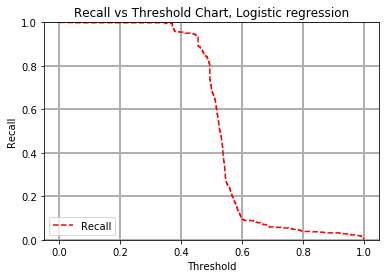

In [80]:
#precision, recall, thresholds = precision_recall_curve(Ytest, clf2.predict_proba(Xtest)[:,1]) 

plt.title("Recall vs Threshold Chart, Logistic regression")
#plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholdsLR, recallLR[: -1], "r--", label="Recall")
plt.ylabel("Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.grid(linestyle='-', linewidth=2)
plt.ylim([0,1])

#### Changing threshold

In [81]:
THRESHOLD=0.4
predictionsLR = clfLR.predict(Xtest)
predictionsLR_prob = pd.DataFrame(clfLR.predict_proba(Xtest)[:,1]).rename(columns = {0:'prob'})
prob = pd.DataFrame(predictionsLR_prob)
true = pd.DataFrame(Ytest)
pred = pd.DataFrame(predictionsLR)

all = pd.merge(true,pred, how = 'left',right_index = True,left_index = True)
all = pd.merge(all,prob, how = 'left',right_index = True,left_index = True)

#print(pd.DataFrame(predictionsLR_prob))
predictions_adj = list([1 if x > THRESHOLD else 0 for x in predictionsLR_prob['prob']])
#print(predictions_adj)
print('results after over sampling, logistic regressioin, no device filtering')

print(classification_report(Ytest, predictionsLR))
print(classification_report(Ytest, predictions_adj))
print(confusion_matrix(Ytest, predictionsLR))




results after over sampling, logistic regressioin, no device filtering
              precision    recall  f1-score   support

           0       1.00      0.43      0.60   9826876
           1       0.00      0.73      0.00       513

    accuracy                           0.43   9827389
   macro avg       0.50      0.58      0.30   9827389
weighted avg       1.00      0.43      0.60   9827389

              precision    recall  f1-score   support

           0       1.00      0.09      0.17   9826876
           1       0.00      0.98      0.00       513

    accuracy                           0.09   9827389
   macro avg       0.50      0.54      0.09   9827389
weighted avg       1.00      0.09      0.17   9827389

[[4179613 5647263]
 [    140     373]]


In [82]:
#plt.plot( predictions3, predictions3_prob, label="Precision v probability")
predProbLR = round(pd.DataFrame(predictionsLR_prob),5).rename(columns = {0: 'probability'})
predLR = pd.DataFrame(predictionsLR).rename(columns = {0: 'prediction'})
predLR = pd.merge(predLR,predProbLR, how = 'left', right_index = True, left_index=True)

In [83]:
predLR.to_csv("~/data/prediction_LogReg20200215.csv")

In [84]:
yscore = clfLR.decision_function(Xtest)


In [85]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = metrics.roc_curve(Ytest, yscore, pos_label=0)
fpr1, tpr1, thresholds1 = metrics.roc_curve(Ytest, yscore, pos_label=1)


### ROC curve

Text(0.5, 0, 'False positive rate')

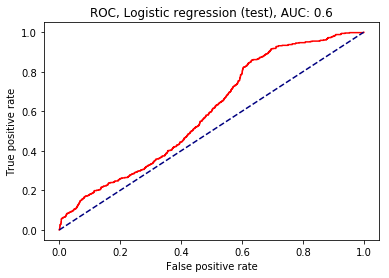

In [126]:
plt.plot(fpr1,tpr1,color='red')
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.title("ROC, Logistic regression (test), AUC: "+ str(round(auc(fpr1,tpr1),2)))
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

### 2. Random Forests

In [87]:
def randomForest(X_train_res, y_train_res):
    #Random forests
    print('starting random forest')
    clfRF = RandomForestClassifier(max_depth=12, random_state=0,max_samples=1000,n_estimators=80).fit(X_train_res, y_train_res)
    print('feature impoartance for RF')
    print(clfRF.feature_importances_)
    pd.DataFrame(clfRF.feature_importances_).to_csv("~/data/featuresSelection.csv")
    filename = 'finalized_model_RF4.sav'
    pickle.dump(clfRF, open(filename, 'wb'))
    return clfRF

In [88]:
print(len(X_train_res.columns))

19


In [89]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
Xtrain_sc = sc.fit_transform(X_train_res)
Xtest_sc = sc.transform(Xtest)

In [100]:
clfRF = randomForest(X_train_res, y_train_res)

#clfRF  = pickle.load(open('finalized_model_RF2.sav', 'rb'))
predictionRF = clfRF.predict(Xtest)
probabilityRF = clfRF.predict_proba(Xtest)

print(classification_report(Ytest, predictionRF))
print(confusion_matrix(Ytest, predictionRF))

starting random forest
feature impoartance for RF
[0.03301243 0.00181764 0.0348758  0.22214637 0.01919977 0.02287007
 0.0236908  0.02472242 0.17517764 0.00501611 0.02636917 0.02072741
 0.01562665 0.01654576 0.02050494 0.03370477 0.26313561 0.0157469
 0.02510974]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98   9826876
           1       0.00      0.70      0.00       513

    accuracy                           0.97   9827389
   macro avg       0.50      0.84      0.49   9827389
weighted avg       1.00      0.97      0.98   9827389

[[9503934  322942]
 [    152     361]]


In [91]:
def confusionMatrix(Y,predictions):
    cm = confusion_matrix(Y, predictions)
    normed_c = (cm.T / cm.astype(np.float).sum(axis=1)).T
    # Normalise
    #cmn = cm.astype('float')
    #cm.sum(axis=0)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(normed_c, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes)
    #plt.ylabel('Actual')
    #plt.xlabel('Predicted')
    plt.show(block=False)

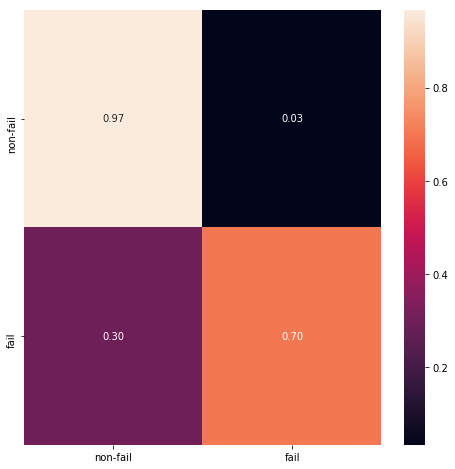

In [101]:
confusionMatrix(Ytest,predictionRF)

Text(0.5, 0, 'False positive rate')

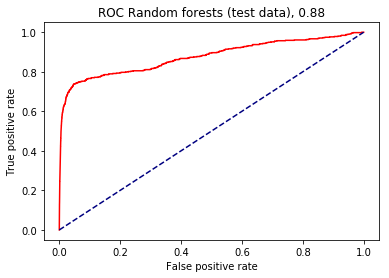

In [102]:
fprRF, tprRF, thresholdsRF = metrics.roc_curve(Ytest, probabilityRF[:,1], pos_label=1)

plt.plot(fprRF,tprRF, color='red')
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.title("ROC Random forests (test data), "+ str(round(auc(fprRF,tprRF),2)))
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

### Validation, Random Forest : #trees - 80, #max_depth - 12


In [93]:
predictionRF = clfRF.predict(Xval) 
probabilityRF = clfRF.predict_proba(Xval)
print(classification_report(Yval, predictionRF)) 
print(confusion_matrix(Yval, predictionRF))
#print(pd.DataFrame(probabilityRF))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98  10213572
           1       0.00      0.75      0.00       626

    accuracy                           0.97  10214198
   macro avg       0.50      0.86      0.49  10214198
weighted avg       1.00      0.97      0.98  10214198

[[9860753  352819]
 [    155     471]]


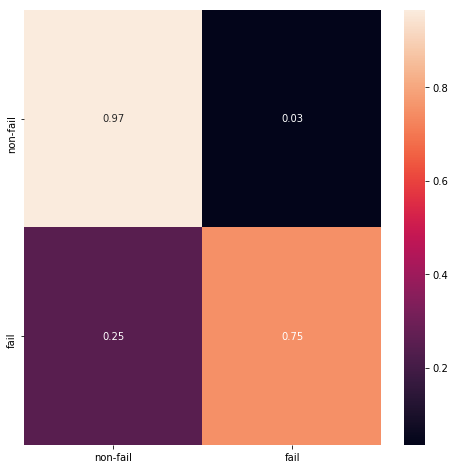

In [94]:
confusionMatrix(Yval, predictionRF)

Text(0.5, 0, 'False positive rate')

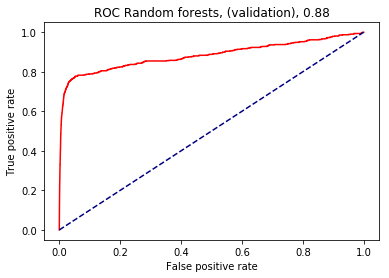

In [98]:
fprRF, tprRF, thresholdsRF = metrics.roc_curve(Yval, probabilityRF[:,1], pos_label=1)

plt.plot(fprRF,tprRF, color='red')
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.title("ROC Random forests (validation), "+ str(round(auc(fprRF,tprRF),2)))
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

### Validation : userdata

In [108]:
Xtest_user,Ytest_user ,info_user = readingUserTestData("~/data/diskStat_2.csv",dfModels, simpleFeatures)

predictionRF = clfRF.predict(Xtest_user) 
probabilityRF = clfRF.predict_proba(Xtest_user)
print(classification_report(Ytest_user, predictionRF)) 
print(confusion_matrix(Ytest_user, predictionRF))
print(pd.DataFrame(probabilityRF))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

[[1]]
          0         1
0  0.115625  0.884375


Text(0.5, 1.0, 'ROC Random forests, failures, 0.88')

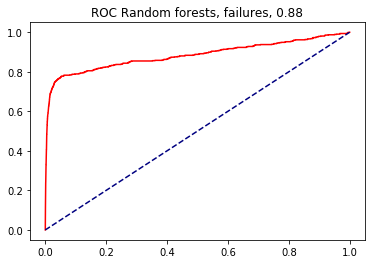

In [95]:
fprRF, tprRF, thresholdsRF = metrics.roc_curve(Yval, probabilityRF[:,1], pos_label=1)

plt.plot(fprRF,tprRF, color='red')
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.title("ROC Random forests, failures, "+ str(round(auc(fprRF,tprRF),2)))

In [109]:
user_prob = pd.DataFrame(probabilityRF).rename(columns = {1:'probabilityRF'})
result = pd.merge(Ytest_user,user_prob[['probabilityRF']], right_index = True,left_index = True)
#print(result)

predRF = pd.DataFrame(predictionRF).rename(columns = {0:'predictions'})
result = pd.merge(result, predRF, right_index = True,left_index =True)


result = pd.merge(result, info_user[['model','capacity_bytes']], right_index = True,left_index =True)
result.to_csv("~/data/dashboardResults.csv")

#.sort_values(by ='probabilityRF', ascending=False)
#print(result)
#print(info_user)

In [110]:
featureRank = pd.read_csv("~/data/featuresSelection.csv").rename(columns={'0': 'rank'})
print(featureRank)

    Unnamed: 0      rank
0            0  0.033012
1            1  0.001818
2            2  0.034876
3            3  0.222146
4            4  0.019200
5            5  0.022870
6            6  0.023691
7            7  0.024722
8            8  0.175178
9            9  0.005016
10          10  0.026369
11          11  0.020727
12          12  0.015627
13          13  0.016546
14          14  0.020505
15          15  0.033705
16          16  0.263136
17          17  0.015747
18          18  0.025110


In [111]:
newFeatureArr=[]
for item in simpleFeatures:
    arr = item.split('_')
    if item=='capacity_bytes':
        id=0
    else:
        id =arr[1]
    newFeatureArr.append(  [id,item] )

featureDict = pd.DataFrame(newFeatureArr).rename(columns={0:'id',1:'name'})
print(featureDict)    

     id            name
0     0  capacity_bytes
1    10    smart_10_raw
2    12    smart_12_raw
3   187   smart_187_raw
4   188   smart_188_raw
5   192   smart_192_raw
6   193   smart_193_raw
7   194   smart_194_raw
8   197   smart_197_raw
9   199   smart_199_raw
10    1     smart_1_raw
11  240   smart_240_raw
12  241   smart_241_raw
13  242   smart_242_raw
14    3     smart_3_raw
15    4     smart_4_raw
16    5     smart_5_raw
17    7     smart_7_raw
18    9     smart_9_raw


In [112]:
dffeatureDict1=dffeatureDict.rename(columns={'name':'fullName'})
#print(dffeatureDict1.dtypes)
featureDict['id'] = [int(x) for x in featureDict['id']]
#print (featureDict1.head())

In [113]:

#featureDict1
featureDict2 = pd.merge(featureDict, dffeatureDict1, how = 'left', right_on = 'id', left_on = 'id').rename(columns={'name_x':'name'})
#print(featureDict2)


In [114]:
#updating feature names for plotting
featureDict2.iloc[0, 2]=featureDict2.iloc[0, 1]
featureDict2.iloc[8, 2]='Current Pending Sector Count'


In [115]:
featureRank = pd.merge(featureDict2, featureRank, how = 'left', right_index = True, left_index = True).rename(columns = {'name_x':'name','fullName_x':'fullName'})
#print(featureRank)

In [116]:
featureRankSorted = featureRank.sort_values(by = 'rank', ascending=False)

In [117]:
top5features = featureRankSorted[['rank', 'id', 'name', 'fullName']]
top5features.to_csv("~/data/top5Features.csv")

top5featuresArr = list(top5features['name'].head())

In [122]:
print(len(top5features))
print((featureDict))

5
     id            name
0     0  capacity_bytes
1    10    smart_10_raw
2    12    smart_12_raw
3   187   smart_187_raw
4   188   smart_188_raw
5   192   smart_192_raw
6   193   smart_193_raw
7   194   smart_194_raw
8   197   smart_197_raw
9   199   smart_199_raw
10    1     smart_1_raw
11  240   smart_240_raw
12  241   smart_241_raw
13  242   smart_242_raw
14    3     smart_3_raw
15    4     smart_4_raw
16    5     smart_5_raw
17    7     smart_7_raw
18    9     smart_9_raw


In [119]:
top5features = pd.read_csv("~/data/top5Features.csv").head()[['rank','fullName']]
print(top5features.head())

       rank                       fullName
0  0.263136      Reallocated Sectors Count
1  0.222146  Reported Uncorrectable Errors
2  0.175178   Current Pending Sector Count
3  0.034876              Power Cycle Count
4  0.033705               Start/Stop Count


In [123]:
allfeatures = pd.read_csv("~/data/top5Features.csv").head()
print(allfeatures)

   Unnamed: 0      rank   id           name                       fullName
0          16  0.263136    5    smart_5_raw      Reallocated Sectors Count
1           3  0.222146  187  smart_187_raw  Reported Uncorrectable Errors
2           8  0.175178  197  smart_197_raw   Current Pending Sector Count
3           2  0.034876   12   smart_12_raw              Power Cycle Count
4          15  0.033705    4    smart_4_raw               Start/Stop Count


In [120]:
print(top5featuresArr)

['smart_5_raw', 'smart_187_raw', 'smart_197_raw', 'smart_12_raw', 'smart_4_raw']


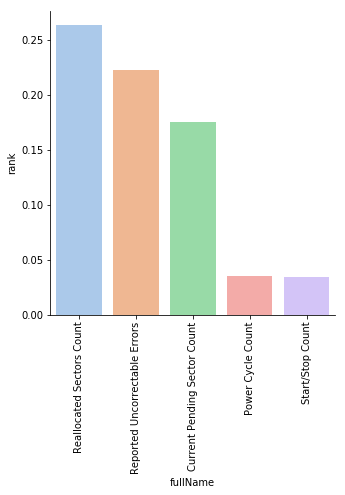

In [121]:
#plt.bar(featureRankSorted.rank,featureRankSorted.name,color='blue')
import seaborn as sns
g = sns.catplot(x="fullName", y="rank",kind = "bar", palette = "pastel",data=top5features.head());
g.set_xticklabels(rotation=90)
#plt.show()

In [111]:
#dfFailStat = dfFailures[top5featuresArr].describe()
#dfSuccessStat = dfSuccess[top5featuresArr].describe()
#dfFailStat.to_csv("~/data/failStat.csv")
#dfSuccessStat.to_csv("~/data/successStat.csv")

/home/ubuntu/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


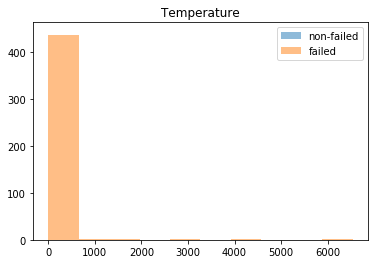

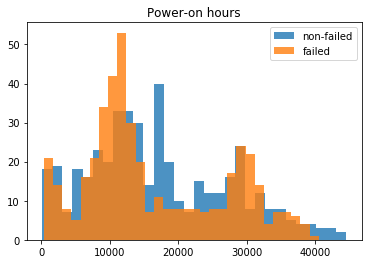

433 0
11 171


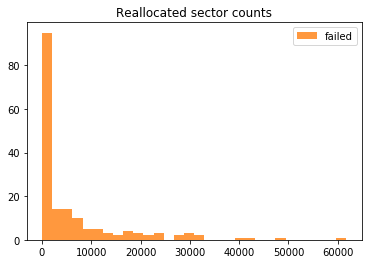

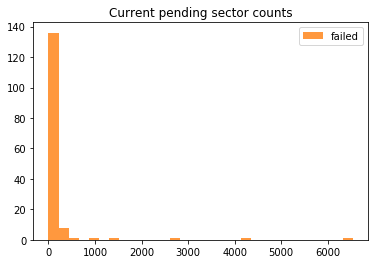

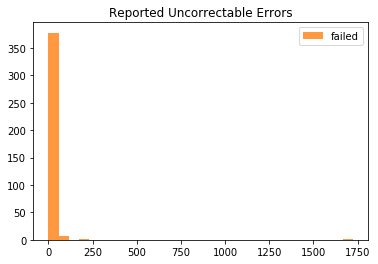

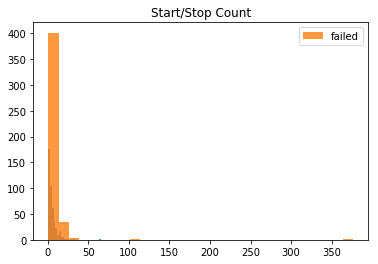

In [124]:


x=list(dfSuccess.sample(n=len(dfFailures)).smart_197_raw)
y=list(dfFailures.smart_197_raw)
#plt.hist([x, y])
plt.hist(x, alpha=0.5, label='non-failed')
plt.hist(y, alpha=0.5, label='failed')
plt.legend(loc='upper right')
plt.title('Temperature')
#plt.legend(loc='upper right')
plt.show()


x=list(dfSuccess.sample(n=len(dfFailures)).smart_9_raw)
y=list(dfFailures.smart_9_raw)
#plt.hist([x, y])
plt.hist(x, alpha=0.8, bins = 30,label='non-failed')
plt.hist(y, alpha=0.8, bins = 30,label='failed')
plt.legend(loc='upper right')
plt.title('Power-on hours')
#plt.legend(loc='upper right')
plt.show()



df_5 = dfSuccess.sample(n=len(dfFailures))
df_5s = df_5[df_5.smart_5_raw>10]
df_5fail = dfFailures[dfFailures.smart_5_raw>10]

print(len(df_5[df_5.smart_5_raw==0]), len(df_5fail[df_5fail.smart_5_raw==10]))
print(len(df_5[df_5.smart_5_raw>0]), len(df_5fail[df_5fail.smart_5_raw>0]))

#print(len(df_5[df_5.smart_5_raw<=10]), len(df_5fail[df_5fail.smart_5_raw<=10]))
#print(len(df_5[df_5.smart_5_raw>10]), len(df_5fail[df_5fail.smart_5_raw>10]))

df_5 = dfSuccess.sample(n=len(dfFailures))
df_197s = df_5[df_5.smart_197_raw>0]
df_197fail = dfFailures[dfFailures.smart_197_raw>0]


#print(df_5s['smart_5_raw'])
x=list(df_5s.smart_5_raw)
y=list(df_5fail.smart_5_raw)
#plt.hist([x, y])
plt.hist(x, alpha=0.8, bins = 30)
plt.hist(y, alpha=0.8, bins = 30,label='failed')
plt.legend(loc='upper right')
plt.title('Reallocated sector counts')
#plt.legend(loc='upper right')
plt.show()



#print(df_197s['smart_197_raw'])
x=list(df_197s.smart_197_raw)
y=list(df_197fail.smart_197_raw)
#plt.hist([x, y])
plt.hist(x, alpha=0.8, bins = 30)
plt.hist(y, alpha=0.8, bins = 30,label='failed')
plt.legend(loc='upper right')
plt.title('Current pending sector counts')
#plt.legend(loc='upper right')
plt.show()




x=list(dfSuccess.sample(n=len(dfFailures)).smart_187_raw)
y=list(dfFailures.smart_187_raw)
#plt.hist([x, y])
plt.hist(x, alpha=0.8, bins = 30)
plt.hist(y, alpha=0.8, bins = 30,label='failed')
plt.legend(loc='upper right')
plt.title('Reported Uncorrectable Errors')
#plt.legend(loc='upper right')
plt.show()



x=list(dfSuccess.sample(n=len(dfFailures)).smart_4_raw)
y=list(dfFailures.smart_4_raw)
#print(df_197s['smart_197_raw'])

#plt.hist([x, y])
plt.hist(x, alpha=0.8, bins = 30)
plt.hist(y, alpha=0.8, bins = 30,label='failed')
plt.legend(loc='upper right')
plt.title('Start/Stop Count')
#plt.legend(loc='upper right')
plt.show()



#print(dfFailures.smart_197_raw)

#sns.distplot(x)

#plt.hist(x, alpha=0.5, label='non-failed')
#plt.hist(y, alpha=0.5, label='failed')
#plt.legend(loc='upper right')
#plt.title('Temperature')
#plt.legend(loc='upper right')
#plt.show()

In [138]:
df_197 = dfSuccess[['smart_197_raw']]
df_197fail = dfFailures[['smart_197_raw']]

In [139]:
print(len(df_197[df_197.smart_197_raw==0]), len(df_197fail[df_197fail.smart_197_raw==10]))
print(len(df_197[df_197.smart_197_raw>0]), len(df_197fail[df_197fail.smart_197_raw>0]))



99511 0
481 150


In [140]:
df_5 = dfSuccess[['smart_5_raw']]
df_5fail = dfFailures[['smart_5_raw']]
print (df_5.mean(),df_5fail.mean())
#print (df_5[['model','serial_number','smart_5_raw']])

smart_5_raw    8.441975
dtype: float64 smart_5_raw    2352.259594
dtype: float64


### Plotting confusion matrix

Confusion matrix, logistic regression
[[4145554 5681322]
 [    138     375]]


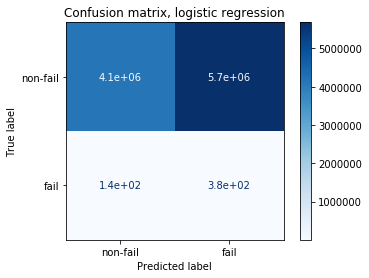

In [204]:
from sklearn.metrics import plot_confusion_matrix

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
title = "Confusion matrix, logistic regression"
normalize = None
class_names = ['non-fail','fail']
disp = plot_confusion_matrix(clfLR, Xtest, Ytest,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.show()

Confusion matrix, Random forests
[[9470416  356460]
 [    146     367]]


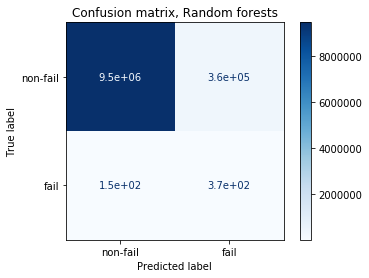

In [205]:
# Plot non-normalized confusion matrix
title = "Confusion matrix, Random forests"
normalize = None
class_names = ['non-fail','fail']
disp = plot_confusion_matrix(clfRF, Xtest, Ytest,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.show()

In [141]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Ytest, predictionsLR))
print('Mean Squared Error:', metrics.mean_squared_error(Ytest, predictionsLR))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Ytest, predictionsLR)))

Mean Absolute Error: 0.5799864033061071
Mean Squared Error: 0.5799864033061071
Root Mean Squared Error: 0.7615683838672054


### Random forest with scaled features

In [142]:
clfRF = randomForest(Xtrain_sc, y_train_res)
predictionRF = clfRF.predict(Xtest_sc)
print(classification_report(Ytest, predictionRF))
print(confusion_matrix(Ytest, predictionRF))

starting random forest
feature impoartance for RF
[3.52787240e-02 1.31693470e-03 3.82130451e-02 2.15133019e-01
 1.24057231e-02 2.41559317e-02 2.38862038e-02 2.50223834e-02
 1.84902320e-01 7.77430280e-03 2.56293649e-02 7.18066410e-07
 1.72168441e-02 2.28325218e-02 1.62137446e-02 3.44924625e-02
 2.71238274e-01 1.65183483e-02 2.77691338e-02]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98   9826876
           1       0.00      0.70      0.00       513

    accuracy                           0.97   9827389
   macro avg       0.50      0.83      0.49   9827389
weighted avg       1.00      0.97      0.98   9827389

[[9500919  325957]
 [    155     358]]


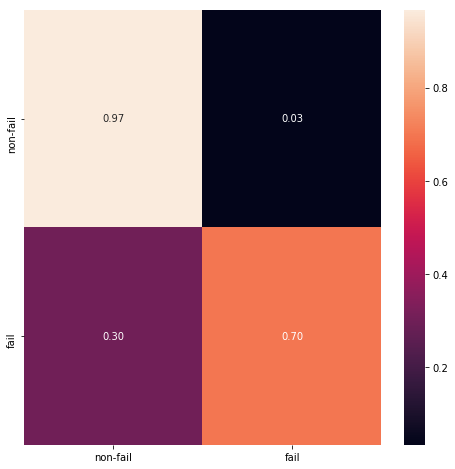

In [143]:
confusionMatrix(Ytest, predictionRF)

In [121]:
#yscore = clfRF.decision_path(Xtest)


In [145]:
dfsampleSuccess = dfSuccess.sample(n = 100000-len(dfFailures))
#dfsampleSuccess = dfSuccess
  
dfsampleFailure = dfFailures


In [146]:
dfBatch = pd.concat([dfsampleSuccess, dfsampleFailure], axis=0)
#dfBatch['modelType'] = dfBatch['modelType']
dfBatch = dstrain

In [147]:
dfBatch.columns

Index(['date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'smart_1_normalized', 'smart_1_raw', 'smart_2_normalized',
       'smart_2_raw', 'smart_3_normalized',
       ...
       'smart_251_raw', 'smart_252_normalized', 'smart_252_raw',
       'smart_254_normalized', 'smart_254_raw', 'smart_255_normalized',
       'smart_255_raw', 'modelName', 'index', 'modelType'],
      dtype='object', length=132)

In [150]:
dfsampleSuccess = dfBatch[dfBatch.failure == 0]
  
dfsampleFailure = dfBatch[dfBatch.failure == 1]

In [151]:
Y = dfBatch[['failure']]

X = dfBatch[simpleFeatures]


X_train0 = X
y_train0 = Y

print("Number transactions X_train dataset: ", X_train0.shape)
print("Number transactions y_train dataset: ", y_train0.shape)


print("Current Time =", datetime.now().strftime("%H:%M:%S"))

X_train = X_train0.fillna(0)



Number transactions X_train dataset:  (100436, 19)
Number transactions y_train dataset:  (100436, 1)
Current Time = 16:59:18


In [152]:
def batchSample(dfsampleSuccess,dfsampleFailure,features):

    dfSuccessbatch = dfsampleSuccess.sample(n =100)
    dfFailurebatch = dfsampleFailure.sample(n = 100)


    dfBatch = pd.concat([dfSuccessbatch, dfFailurebatch], axis=0)

    #print(dfBatch[['failure']])


    X_batch = dfBatch[features].fillna(0)
    y_batch = dfBatch['failure']


    return X_batch,y_batch




In [153]:
def SDG(dfsampleSuccess,dfsampleFailure,features,iter):
    print(features)
    SDGmodel = linear_model.SGDClassifier(max_iter=5, tol=1e-12, loss='log',penalty='elasticnet')
    for i in range(0, iter):
        x_batch, y_batch=batchSample(dfsampleSuccess,dfsampleFailure,features)
            #print(y_batch)
        clf = SDGmodel.partial_fit(x_batch, y_batch,classes=np.unique(y_batch))
    return clf

In [134]:
#print('Starting SGD...')
#print("Current Time =", datetime.now().strftime("%H:%M:%S"))
#simpleFeaturesHist = ['capacity_bytes','smart_1_raw', 'smart_5_raw', 'smart_7_raw','smart_9_raw', 'smart_12_raw','smart_188_raw','smart_189_raw','smart_190_raw','smart_192_raw', 'smart_194_raw', 'smart_195_raw','smart_197_raw', 'smart_199_raw','smart_200_raw', 'smart_240_raw','smart_241_raw']



#clf = SDG(dfsampleSuccess,dfsampleFailure,simpleFeatures,200)


#prediction = clf.predict(Xtest)
#print(confusion_matrix(Ytest,prediction))
#print(classification_report(Ytest, prediction, zero_division=1))

In [157]:
featureStat = (dfsampleFailure[simpleFeatures] - dfsampleFailure[simpleFeatures].mean()) / dfsampleFailure[simpleFeatures].std()  

In [158]:
print(featureStat[top5featuresArr])

         smart_5_raw  smart_197_raw  smart_187_raw  capacity_bytes  \
68859      -0.228841      -0.142205      -0.129195       -0.954631   
69646      -0.332320      -0.082617       0.444336       -0.954631   
91761       3.918371      -0.142205       1.130324        0.028381   
103428     -0.338069      -0.142205      -0.129195        0.028381   
133801     -0.294378      -0.142205      -0.129195        1.010852   
177341     -0.333470       0.910516       0.298142       -0.954631   
178242     -0.338069      -0.062755      -0.084212       -0.954631   
184759     -0.338069      -0.142205      -0.129195       -1.814766   
189586      0.412729      -0.142205       0.118211        0.028381   
244240     -0.338069      -0.142205      -0.129195        1.010852   
254823      3.688417      -0.142205       0.118211        1.010852   
264884      0.412154      -0.142205      -0.117949        1.010852   
268421     -0.205846      -0.122343       0.028245       -0.954631   
291297     -0.338069

In [144]:
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

### Support vector machine

In [ ]:
def runSVM(X_train_res, y_train_res):
    clf = svm.SVC().fit(X_train_res, y_train_res)
    return clf

In [163]:
def runLinearSVM(X_train_res, y_train_res):
    clf = LinearSVC(random_state=0, tol=1e-5, max_iter = 10000).fit(X_train_res, y_train_res)
    return clf

In [ ]:
clfSVC = runLinearSVM(X_train_res, y_train_res)
#clfSVM = runSVM(X_train_res, y_train_res)

In [161]:
#predictionSVM = clfSVM.predict(Xtest)
predictionSVM = clfSVC.predict(Xtest)  #Linear SVM

In [162]:
print(confusion_matrix(Ytest,predictionSVM))
print(classification_report(Ytest, predictionSVM, zero_division=1))

[[  48055 9778821]
 [      2     511]]
              precision    recall  f1-score   support

           0       1.00      0.00      0.01   9826876
           1       0.00      1.00      0.00       513

    accuracy                           0.00   9827389
   macro avg       0.50      0.50      0.00   9827389
weighted avg       1.00      0.00      0.01   9827389



### SVM, validation

In [ ]:
predictionSVM = clfSVM.predict(Xval)
print(confusion_matrix(Yval,predictionSVM))
print(classification_report(Yval, predictionSVM, zero_division=1))

In [ ]:
from imblearn.under_sampling import ClusterCentroids

In [17]:
def regressionUnderSampling(X, y):
    print('calculate under-sampling')

    cc = ClusterCentroids(random_state=0)
    X_resampled, y_resampled = cc.fit_resample(X, y)

    print('Results with under-sampling')
    return X_resampled, y_resampled

### Neural Network

In [127]:

from sklearn.neural_network import MLPClassifier


In [128]:
clfNN = MLPClassifier().fit(X_train_res,y_train_res)
#clfNN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1).fit(X_train_res, y_train_res)


#clf.fit(X, y)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [134]:
predictionNN = clfNN.predict(Xval)

In [135]:
print(confusion_matrix(Yval,predictionNN))
print(classification_report(Yval, predictionNN))

[[2987647 7225925]
 [    112     514]]
              precision    recall  f1-score   support

           0       1.00      0.29      0.45  10213572
           1       0.00      0.82      0.00       626

    accuracy                           0.29  10214198
   macro avg       0.50      0.56      0.23  10214198
weighted avg       1.00      0.29      0.45  10214198



In [131]:
predictionNN = clfNN.predict(Xval)
print(confusion_matrix(Yval,predictionNN))
print(classification_report(Yval, predictionNN))

[[2987647 7225925]
 [    112     514]]
              precision    recall  f1-score   support

           0       1.00      0.29      0.45  10213572
           1       0.00      0.82      0.00       626

    accuracy                           0.29  10214198
   macro avg       0.50      0.56      0.23  10214198
weighted avg       1.00      0.29      0.45  10214198



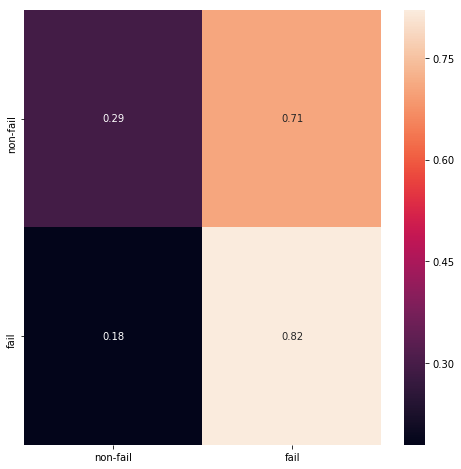

In [137]:
confusionMatrix(Yval, predictionNN)